In [137]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import QTable, Table, Column
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from statsmodels.tsa.ar_model import AutoReg

In [17]:
# Load the data
GSK = pd.read_csv('data/GSK.csv',index_col=0, parse_dates=True)
JNJ = pd.read_csv('data/JNJ.csv',index_col=0, parse_dates=True)
MRK = pd.read_csv('data/MRK.csv',index_col=0, parse_dates=True)
PFE = pd.read_csv('data/PFE.csv',index_col=0, parse_dates=True)
SNY = pd.read_csv('data/SNY.csv',index_col=0, parse_dates=True)

In [58]:
# Get the trends data
trends = GSK[['Virus', 'Flu', 'Vaccine']]
trends.head()

,Virus,Flu,Vaccine
Date,,,
2010-11-01,5,12,13
2010-12-01,5,16,9
2011-01-01,5,18,12
2011-02-01,5,13,12
2011-03-01,5,9,13


Text(0, 0.5, 'Score')

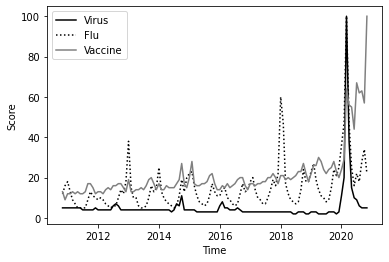

In [71]:
# Visualize the trends data
plt.plot(trends.index, trends['Virus'], color = 'black', label = 'Virus')
plt.plot(trends.index, trends['Flu'], color = 'black', label = 'Flu', linestyle=":")
plt.plot(trends.index, trends['Vaccine'], color = 'gray', label = 'Vaccine')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Score')

In [115]:
GSK['log_Adj_Close'] = np.log(GSK['Adj Close'])
JNJ['log_Adj_Close'] = np.log(JNJ['Adj Close'])
MRK['log_Adj_Close'] = np.log(MRK['Adj Close'])
PFE['log_Adj_Close'] = np.log(PFE['Adj Close'])
SNY['log_Adj_Close'] = np.log(SNY['Adj Close'])

In [139]:
model = AutoReg(GSK.iloc[1:]['log_Adj_Close'], lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept           0.320391
log_Adj_Close.L1    0.909533
dtype: float64


C:\Users\symay\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [140]:
model = AutoReg(JNJ.iloc[1:]['log_Adj_Close'], lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: intercept           0.071115
log_Adj_Close.L1    0.986276
dtype: float64


C:\Users\symay\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [116]:
def base_prediction(stock):
    '''This function build the base AR-1 model y_t = b_1*y_t-1 + b_12*y_t-12 + e_t 
    and make the prediction accordingly'''
    predict_list = []

    for index_i in stock.index:    
        #use loc and iloc to get the prior date
        loc1 = stock.index.get_loc(index_i)
        if(loc1<20):continue
        predictor = [stock.iloc[loc1 - 1]['log_Adj_Close'],stock.iloc[loc1 - 12]['log_Adj_Close']]
        predictor = np.array(predictor).reshape(1,-1)
        #new list for variables and values for linear regression
        X = []
        Y = []
        for index_j, rows in (stock[(stock.index<index_i)]).iterrows():
            loc2 = stock.index.get_loc(index_j)
            if(loc2<17):continue
            predictors = [stock.iloc[loc2-1]['log_Adj_Close'],stock.iloc[loc2 - 12]['log_Adj_Close']]
            X.append(predictors)
            actual = stock.loc[index_j]['log_Adj_Close']
            Y.append(actual)
        #predictors and actual values in rolling window
        X = np.array(X)
        Y = np.array(Y)
        #optimal parameters from OLS
        linreg = LinearRegression().fit(X, Y)
        #predicted values    
        pre = linreg.predict(predictor)[0]
        predict_list.append(pre)
    
    return predict_list

In [117]:
# Make the base prediction for five stocks
GSK_base = base_prediction(GSK)
JNJ_base = base_prediction(JNJ)
MRK_base = base_prediction(MRK)
PFE_base = base_prediction(PFE)
SNY_base = base_prediction(SNY)

In [118]:
# Get the actual stock price
GSK_actual = GSK['log_Adj_Close'][20:]
JNJ_actual = JNJ['log_Adj_Close'][20:]
MRK_actual = MRK['log_Adj_Close'][20:]
PFE_actual = PFE['log_Adj_Close'][20:]
SNY_actual = SNY['log_Adj_Close'][20:]

In [119]:
MAE_GSK_b = MAE(GSK_base,GSK_actual)
MAE_JNJ_b = MAE(JNJ_base,JNJ_actual)
MAE_MRK_b = MAE(MRK_base,MRK_actual)
MAE_PFE_b = MAE(PFE_base,PFE_actual)
MAE_SNY_b = MAE(SNY_base,SNY_actual)

In [121]:
def virus_prediction(stock):
    predict_list = []

    for index_i in stock.index:
        
        #use loc and iloc to get the prior date
        loc1 = stock.index.get_loc(index_i)
        if(loc1<20):continue
        predictor = [stock.iloc[loc1 - 1]['log_Adj_Close'],stock.iloc[loc1 - 12]['log_Adj_Close'],stock.iloc[loc1]['Virus']]
        predictor = np.array(predictor).reshape(1,-1)
        #new list for variables and values for linear regression
        X = []
        Y = []
        for index_j, rows in (stock[(stock.index<index_i)]).iterrows():
            loc2 = stock.index.get_loc(index_j)
            if(loc2<17):continue
            predictors = [stock.iloc[loc2-1]['log_Adj_Close'],stock.iloc[loc2-12]['log_Adj_Close'],stock.iloc[loc2]['Virus']]
            X.append(predictors)
            actual = stock.loc[index_j]['log_Adj_Close']
            Y.append(actual)
        #predictors and actual values in rolling window
        X = np.array(X)
        Y = np.array(Y)
        #optimal parameters from OLS
        linreg = LinearRegression().fit(X, Y)
        #predicted values    
        pre = linreg.predict(predictor)[0]
        predict_list.append(pre)
    
    return predict_list

In [122]:
GSK_virus = virus_prediction(GSK)
JNJ_virus = virus_prediction(JNJ)
MRK_virus = virus_prediction(MRK)
PFE_virus = virus_prediction(PFE)
SNY_virus = virus_prediction(SNY)

In [123]:
MAE_GSK_vi = MAE(GSK_virus,GSK_actual)
MAE_JNJ_vi = MAE(JNJ_virus,JNJ_actual)
MAE_MRK_vi = MAE(MRK_virus,MRK_actual)
MAE_PFE_vi = MAE(PFE_virus,PFE_actual)
MAE_SNY_vi = MAE(SNY_virus,SNY_actual)

In [124]:
def flu_prediction(stock):
    predict_list = []

    for index_i in stock.index:
        
        #use loc and iloc to get the prior date
        loc1 = stock.index.get_loc(index_i)
        if(loc1<20):continue
        predictor = [stock.iloc[loc1 - 1]['log_Adj_Close'],stock.iloc[loc1 - 12]['log_Adj_Close'],stock.loc[index_i]['Flu']]
        predictor = np.array(predictor).reshape(1,-1)
        #new list for variables and values for linear regression
        X = []
        Y = []
        for index_j, rows in (stock[(stock.index<index_i)]).iterrows():
            loc2 = stock.index.get_loc(index_j)
            if(loc2<17):continue
            predictors = [stock.iloc[loc2-1]['log_Adj_Close'],stock.iloc[loc2-12]['log_Adj_Close'],stock.loc[index_j]['Flu']]
            X.append(predictors)
            actual = stock.loc[index_j]['log_Adj_Close']
            Y.append(actual)
        #predictors and actual values in rolling window
        X = np.array(X)
        Y = np.array(Y)
        #optimal parameters from OLS
        linreg = LinearRegression().fit(X, Y)
        #predicted values    
        pre = linreg.predict(predictor)[0]
        predict_list.append(pre)
    
    return predict_list

In [125]:
GSK_flu = flu_prediction(GSK)
JNJ_flu = flu_prediction(JNJ)
MRK_flu = flu_prediction(MRK)
PFE_flu = flu_prediction(PFE)
SNY_flu = flu_prediction(SNY)

In [126]:
MAE_GSK_f = MAE(GSK_flu,GSK_actual)
MAE_JNJ_f = MAE(JNJ_flu,JNJ_actual)
MAE_MRK_f = MAE(MRK_flu,MRK_actual)
MAE_PFE_f = MAE(PFE_flu,PFE_actual)
MAE_SNY_f = MAE(SNY_flu,SNY_actual)

In [127]:
def vaccine_prediction(stock):
    predict_list = []

    for index_i in stock.index:
        
        #use loc and iloc to get the prior date
        loc1 = stock.index.get_loc(index_i)
        if(loc1<20):continue
        predictor = [stock.iloc[loc1 - 1]['log_Adj_Close'],stock.iloc[loc1 - 12]['log_Adj_Close'],stock.loc[index_i]['Vaccine']]
        predictor = np.array(predictor).reshape(1,-1)
        #new list for variables and values for linear regression
        X = []
        Y = []
        for index_j, rows in (stock[(stock.index<index_i)]).iterrows():
            loc2 = stock.index.get_loc(index_j)
            if(loc2<17):continue
            predictors = [stock.iloc[loc2-1]['log_Adj_Close'],stock.iloc[loc2-12]['log_Adj_Close'],stock.loc[index_j]['Vaccine']]
            X.append(predictors)
            actual = stock.loc[index_j]['log_Adj_Close']
            Y.append(actual)
        #predictors and actual values in rolling window
        X = np.array(X)
        Y = np.array(Y)
        #optimal parameters from OLS
        linreg = LinearRegression().fit(X, Y)
        #predicted values    
        pre = linreg.predict(predictor)[0]
        predict_list.append(pre)
    
    return predict_list

In [128]:
GSK_vaccine = vaccine_prediction(GSK)
JNJ_vaccine = vaccine_prediction(JNJ)
MRK_vaccine = vaccine_prediction(MRK)
PFE_vaccine = vaccine_prediction(PFE)
SNY_vaccine = vaccine_prediction(SNY)

In [129]:
MAE_GSK_va = MAE(GSK_vaccine,GSK_actual)
MAE_JNJ_va = MAE(JNJ_vaccine,JNJ_actual)
MAE_MRK_va = MAE(MRK_vaccine,MRK_actual)
MAE_PFE_va = MAE(PFE_vaccine,PFE_actual)
MAE_SNY_va = MAE(SNY_vaccine,SNY_actual)

Text(0, 0.5, 'Stock Price')

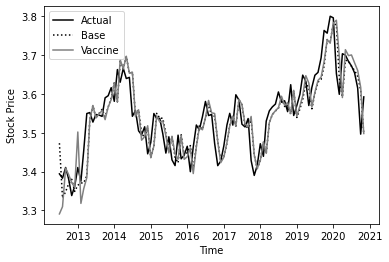

In [130]:
plt.plot(GSK.index[20:],GSK_actual, color='black', label='Actual')
plt.plot(GSK.index[20:],GSK_base, color='black', label='Base', linestyle=":")
plt.plot(GSK.index[20:],GSK_vaccine, color='gray', label='Vaccine')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')

Text(0, 0.5, 'Stock Price')

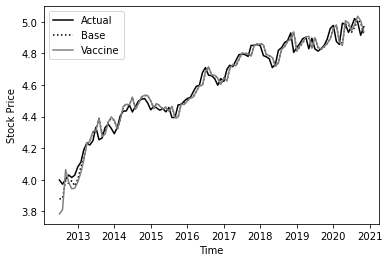

In [131]:
plt.plot(JNJ.index[20:],JNJ_actual, color='black', label='Actual')
plt.plot(JNJ.index[20:],JNJ_base, color='black', label='Base', linestyle=":")
plt.plot(JNJ.index[20:],JNJ_vaccine, color='gray', label='Vaccine')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')

In [132]:
def trends_prediction(stock):
    predict_list = []

    for index_i in stock.index:
        
        #use loc and iloc to get the prior date
        loc1 = stock.index.get_loc(index_i)
        if(loc1<20):continue
        predictor = [stock.iloc[loc1 - 1]['log_Adj_Close'],stock.iloc[loc1 - 12]['log_Adj_Close'],stock.iloc[loc1]['Vaccine'],stock.iloc[loc1]['Virus'],stock.iloc[loc1]['Flu']]
        predictor = np.array(predictor).reshape(1,-1)
        #new list for variables and values for linear regression
        X = []
        Y = []
        for index_j, rows in (stock[(stock.index<index_i)]).iterrows():
            loc2 = stock.index.get_loc(index_j)
            if(loc2<17):continue
            predictors = [stock.iloc[loc2 - 1]['log_Adj_Close'],stock.iloc[loc2 - 12]['log_Adj_Close'],stock.iloc[loc2]['Vaccine'],stock.iloc[loc2]['Virus'],stock.iloc[loc2]['Flu']]
            X.append(predictors)
            actual = stock.loc[index_j]['log_Adj_Close']
            Y.append(actual)
        #predictors and actual values in rolling window
        X = np.array(X)
        Y = np.array(Y)
        #optimal parameters from OLS
        linreg = LinearRegression().fit(X, Y)
        #predicted values    
        pre = linreg.predict(predictor)[0]
        predict_list.append(pre)
    
    return predict_list

In [133]:
GSK_trends = trends_prediction(GSK)
JNJ_trends = trends_prediction(JNJ)
MRK_trends = trends_prediction(MRK)
PFE_trends = trends_prediction(PFE)
SNY_trends = trends_prediction(SNY)

In [134]:
MAE_GSK_t = MAE(GSK_trends,GSK_actual)
MAE_JNJ_t = MAE(JNJ_trends,JNJ_actual)
MAE_MRK_t = MAE(MRK_trends,MRK_actual)
MAE_PFE_t = MAE(PFE_trends,PFE_actual)
MAE_SNY_t = MAE(SNY_trends,SNY_actual)

In [135]:
# Compute 1-ratio
# virus
ratio_GSK_vi = (MAE_GSK_vi-MAE_GSK_b)/MAE_GSK_b *100
ratio_JNJ_vi = (MAE_JNJ_vi-MAE_JNJ_b)/MAE_GSK_b *100
ratio_MRK_vi = (MAE_MRK_vi-MAE_MRK_b)/MAE_MRK_b *100
ratio_PFE_vi = (MAE_PFE_vi-MAE_PFE_b)/MAE_PFE_b *100
ratio_SNY_vi = (MAE_SNY_vi-MAE_SNY_b)/MAE_SNY_b *100
# flu
ratio_GSK_f = (MAE_GSK_f-MAE_GSK_b)/MAE_GSK_b *100
ratio_JNJ_f = (MAE_JNJ_f-MAE_JNJ_b)/MAE_GSK_b *100
ratio_MRK_f = (MAE_MRK_f-MAE_MRK_b)/MAE_MRK_b *100
ratio_PFE_f = (MAE_PFE_f-MAE_PFE_b)/MAE_PFE_b *100
ratio_SNY_f = (MAE_SNY_f-MAE_SNY_b)/MAE_SNY_b *100
# vaccine
ratio_GSK_va = (MAE_GSK_va-MAE_GSK_b)/MAE_GSK_b *100
ratio_JNJ_va = (MAE_JNJ_va-MAE_JNJ_b)/MAE_GSK_b *100
ratio_MRK_va = (MAE_MRK_va-MAE_MRK_b)/MAE_MRK_b *100
ratio_PFE_va = (MAE_PFE_va-MAE_PFE_b)/MAE_PFE_b *100
ratio_SNY_va = (MAE_SNY_va-MAE_SNY_b)/MAE_SNY_b *100
# Trends
ratio_GSK_t = (MAE_GSK_t-MAE_GSK_b)/MAE_GSK_b *100
ratio_JNJ_t = (MAE_JNJ_t-MAE_JNJ_b)/MAE_GSK_b *100
ratio_MRK_t = (MAE_MRK_t-MAE_MRK_b)/MAE_MRK_b *100
ratio_PFE_t = (MAE_PFE_t-MAE_PFE_b)/MAE_PFE_b *100
ratio_SNY_t = (MAE_SNY_t-MAE_SNY_b)/MAE_SNY_b *100

In [136]:
# Compare the MAE value
data_rows = (['GSK', round(MAE_GSK_b,5), round(MAE_GSK_vi,5), round(MAE_GSK_f,5), round(MAE_GSK_va,5), round(MAE_GSK_t,5)],
             ['JNJ', round(MAE_JNJ_b,5), round(MAE_JNJ_vi,5), round(MAE_JNJ_f,5), round(MAE_JNJ_va,5), round(MAE_JNJ_t,5)],
             ['MRK', round(MAE_MRK_b,5), round(MAE_MRK_vi,5), round(MAE_MRK_f,5), round(MAE_MRK_va,5), round(MAE_MRK_t,5)],
             ['PFE', round(MAE_PFE_b,5), round(MAE_PFE_vi,5), round(MAE_PFE_f,5), round(MAE_PFE_va,5), round(MAE_PFE_t,5)],
             ['SNY', round(MAE_SNY_b,5), round(MAE_SNY_vi,5), round(MAE_SNY_f,5), round(MAE_SNY_va,5), round(MAE_SNY_t,5)])
t1 = Table(rows=data_rows, names=('Stock', 'MAE_base', 'MAE_virus', 'MAE_flu', 'MAE_vaccine','MAE_trends'))
#print('       Behavio of MAE around Turning Points')
print(t1)

Stock MAE_base MAE_virus MAE_flu MAE_vaccine MAE_trends
----- -------- --------- ------- ----------- ----------
  GSK  0.04187   0.04849 0.04256     0.04467    0.05154
  JNJ  0.03698     0.041 0.04014      0.0408    0.04804
  MRK  0.04551   0.05451 0.04658     0.04661    0.05812
  PFE  0.04321   0.04863 0.04518     0.04766    0.05409
  SNY  0.05676   0.07108 0.05625     0.05836    0.06639


In [114]:
# Compare the 1-ratio
data_rows = (['GSK', round(ratio_GSK_vi,2), round(ratio_GSK_f,2), round(ratio_GSK_va,2), round(ratio_GSK_t,2)],
             ['JNJ', round(ratio_JNJ_vi,2), round(ratio_JNJ_f,2), round(ratio_JNJ_va,2), round(ratio_JNJ_t,2)],
             ['MRK', round(ratio_MRK_vi,2), round(ratio_MRK_f,2), round(ratio_MRK_va,2), round(ratio_MRK_t,2)],
             ['PFE', round(ratio_PFE_vi,2), round(ratio_PFE_f,2), round(ratio_PFE_va,2), round(ratio_PFE_t,2)],
             ['SNY', round(ratio_SNY_vi,2), round(ratio_SNY_f,2), round(ratio_SNY_va,2), round(ratio_SNY_t,2)])
t2 = Table(rows=data_rows, names=('Stock', '1-ratio_virus', '1-ratio_flu', '1-ratio_vaccine','1-ratio_trends'))
#print('       Behavio of MAE around Turning Points')
print(t2)

Stock 1-ratio_virus 1-ratio_flu 1-ratio_vaccine 1-ratio_trends
----- ------------- ----------- --------------- --------------
  GSK         24.09        7.18           11.93          29.36
  JNJ         28.06        5.84           15.48          72.04
  MRK         23.25       14.42            9.89          27.17
  PFE         14.32        4.33            10.0          23.96
  SNY         40.32       26.88           25.14          38.79


Text(0, 0.5, 'Stock Price')

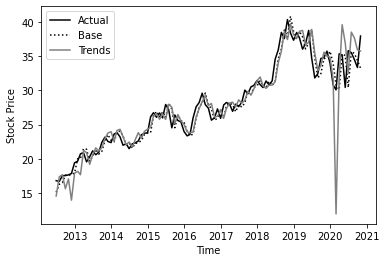

In [103]:
plt.plot(PFE.index[20:],PFE_actual, color='black', label='Actual')
plt.plot(PFE.index[20:],PFE_base, color='black', label='Base', linestyle=":")
plt.plot(PFE.index[20:],PFE_trends, color='gray', label='Trends')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')

Text(0, 0.5, 'Stock Price')

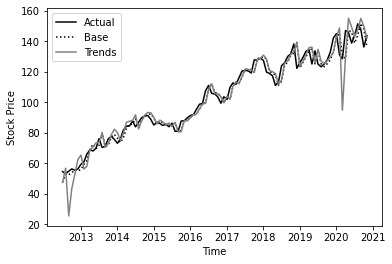

In [104]:
plt.plot(JNJ.index[20:],JNJ_actual, color='black', label='Actual')
plt.plot(JNJ.index[20:],JNJ_base, color='black', label='Base', linestyle=":")
plt.plot(JNJ.index[20:],JNJ_trends, color='gray', label='Trends')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')

Text(0, 0.5, 'Stock Price')

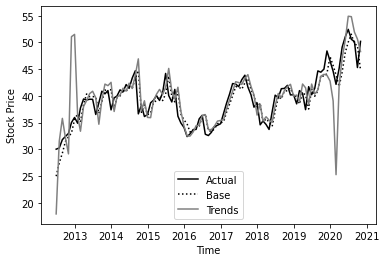

In [105]:
plt.plot(SNY.index[20:],SNY_actual, color='black', label='Actual')
plt.plot(SNY.index[20:],SNY_base, color='black', label='Base', linestyle=":")
plt.plot(SNY.index[20:],SNY_trends, color='gray', label='Trends')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')

Text(0, 0.5, 'Stock Price')

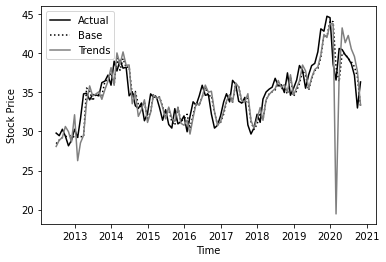

In [106]:
plt.plot(GSK.index[20:],GSK_actual, color='black', label='Actual')
plt.plot(GSK.index[20:],GSK_base, color='black', label='Base', linestyle=":")
plt.plot(GSK.index[20:],GSK_trends, color='gray', label='Trends')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Stock Price')